In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from scipy import stats
from scipy.stats import zscore
from math import radians, cos, sin, asin, sqrt
import pydot_ng as pydot
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

import tensorflow as tf

In [5]:
depev = pd.read_csv('depev_final.csv')
depev.drop(depev.columns[depev.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
depev2 = depev.drop(['HHX'], axis=1)
depev2.head()

,URBRRL,RATCAT_A,INCGRP_A,INCTCFLG_A,FAMINCTC_A,IMPINCFLG_A,PPSU,PSTRAT,HISPALLP_A,RACEALLP_A,...,ANGEV_A,CHDEV_A,CHLEV_A,HYPEV_A,PHSTAT_A,AVAIL_A,INTV_QRT,WTFA_A,WTIA_A,POVRATTC_A
0,4,9,3,0,60000,2,2,122,3,2,...,2,2,1,2,3,1,1,13177.008,7601.336,2.96
1,4,9,3,0,50000,0,2,122,2,1,...,2,2,2,2,1,1,1,6140.552,3344.434,2.97
2,4,12,3,0,65000,1,2,122,2,1,...,2,2,1,1,3,1,1,9191.061,6949.498,4.28
3,4,14,5,0,120000,0,2,122,1,8,...,2,2,2,1,2,1,1,7900.035,6446.327,7.13
4,1,4,1,0,30000,0,2,115,2,1,...,1,1,1,1,4,1,1,10875.772,8646.586,1.13


In [9]:
phq = depev[['PHQ88_A', 'PHQ87_A', 'PHQ86_A', 'PHQ85_A', 'PHQ84_A', 'PHQ83_A', 'PHQ82_A', 'PHQ81_A', 'DEPEV_A']]
phq.head()

,PHQ88_A,PHQ87_A,PHQ86_A,PHQ85_A,PHQ84_A,PHQ83_A,PHQ82_A,PHQ81_A,DEPEV_A
0,1,1,1,1,1,1,1,1,2
1,1,2,1,1,1,1,1,1,2
2,1,1,1,1,1,2,1,1,2
3,1,1,1,1,1,2,1,1,2
4,1,4,2,2,3,2,3,4,1


This is using the 8 Patient Health Questionnaire questions used to assess depression/anxiety to predict whether the patient has depression (DEPEV_A).

In [10]:
phq = phq.sample(frac=1)

train = phq.sample(frac=0.8)
print('Train:' + str(train.shape))

validate = phq.sample(frac=0.1)
print('Validate:' + str(validate.shape))

test = phq.sample(frac=0.1)
print('Test:' + str(test.shape))

label_column = 'DEPEV_A'
phq_label = depev[['DEPEV_A']].to_numpy()

Train:(25567, 9)
Validate:(3196, 9)
Test:(3196, 9)


In [11]:
x_train = train.drop(['DEPEV_A'], axis=1)
x_train = np.asarray(x_train).astype(np.float32)
y_train = train[['DEPEV_A']].to_numpy()
y_train = np.asarray(y_train).astype(np.float32)

x_val = validate.drop(['DEPEV_A'], axis=1)
x_val = np.asarray(x_val).astype(np.float32)
y_val = validate[['DEPEV_A']].to_numpy()
y_val = np.asarray(y_val).astype(np.float32)

x_test = test.drop(['DEPEV_A'], axis=1)
x_test = np.asarray(x_test).astype(np.float32)
y_test = test[['DEPEV_A']].to_numpy()
y_test = np.asarray(y_test).astype(np.float32)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(25567, 8)
(25567, 1)
(3196, 8)
(3196, 1)
(3196, 8)
(3196, 1)


In [14]:
xsize=8
ysize=1

t_model = Sequential()
t_model.add(Dense(100, activation="relu", input_shape=(xsize,)))
t_model.add(Dense(50, activation="relu"))
t_model.add(Dense(ysize))
t_model.compile(
    loss="mean_squared_error",
    optimizer=Adam(lr=0.001),
    metrics=[metrics.mae])

2022-08-03 15:18:09.286205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/josephsun/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
epochs = 100
batch = 128

# cols = list(train.columns)
# cols.remove(label_column)
history = t_model.fit(
    x_train, y_train,
    batch_size=batch,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    validation_data=(x_val,y_val)
)
score = t_model.evaluate(x_test, y_test, verbose=0)

Epoch 1/100
200/200 [==============================] - 1s 2ms/step - loss: 0.5949 - mean_absolute_error: 0.5688 - val_loss: 0.1516 - val_mean_absolute_error: 0.2188
Epoch 2/100
200/200 [==============================] - 0s 1ms/step - loss: 0.1575 - mean_absolute_error: 0.2289 - val_loss: 0.1710 - val_mean_absolute_error: 0.2159
Epoch 3/100
200/200 [==============================] - 0s 1ms/step - loss: 0.1558 - mean_absolute_error: 0.2266 - val_loss: 0.1452 - val_mean_absolute_error: 0.2401
Epoch 4/100
200/200 [==============================] - 0s 1ms/step - loss: 0.1532 - mean_absolute_error: 0.2238 - val_loss: 0.1448 - val_mean_absolute_error: 0.1913
Epoch 5/100
200/200 [==============================] - 0s 1ms/step - loss: 0.1497 - mean_absolute_error: 0.2198 - val_loss: 0.1450 - val_mean_absolute_error: 0.1834
Epoch 6/100
200/200 [==============================] - 0s 1ms/step - loss: 0.1506 - mean_absolute_error: 0.2213 - val_loss: 0.1384 - val_mean_absolute_error: 0.2193
Epoch 7/10

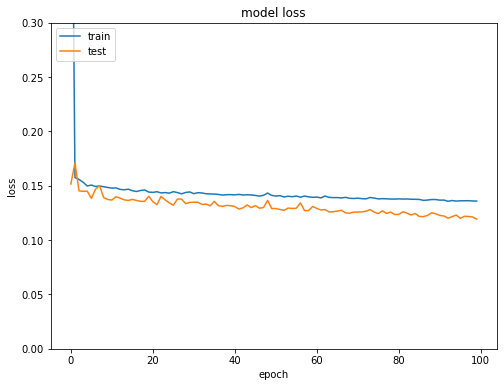

In [20]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0, 0.3])
plt.show()